<a href="https://colab.research.google.com/github/Kaiziferr/machine_learning/blob/main/randomforest/clasification/01_carseats_randomforest_clasification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
import multiprocessing
import numpy as np
import seaborn as sns
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score, train_test_split, RepeatedKFold, GridSearchCV, ParameterGrid
from sklearn.inspection import permutation_importance

# **Description**
---
El conjunto de datos `Carseats` contiene información sobre la venta de sillas infantiles en 400 tiendas distintas.

# **Objetivo**
---
Generar un modelo de clasificación que permita predecir si una tienda tiene ventas altas (Ventas > 8) o bajas (Ventas <= 8) en función de todas las variables disponibles.


# **Diccionario de datos**
---

- `Sales`: ventas unitarias (en miles) en cada ubicación
- `CompPrice`: precio cobrado por el competidor en cada ubicación
- `Income`: nivel de ingresos de la comunidad (en miles de dólares)
- `Advertising`: presupuesto de publicidad local para la empresa en cada ubicación (en miles de dólares)
- `Population`: tamaño de la población en la región (en miles)
- `Price`: precio de los cargos de la compañía por los asientos de seguridad en cada sitio
- `ShelveLoc`: un factor con niveles que Badindica la calidad de la ubicación de las estanterías para los asientos de automóvil en cada sitio good and medium
- `Age`: edad media de la población local
- `Education`: nivel de educación en cada lugar
- `Urban`: un factor con niveles No o yes para indicar si la tienda está en una zona urbana o rural
- `US`: un factor con niveles No o yes para indicar si la tienda está en USA o no















# **data**
---

In [2]:
carseats = sm.datasets.get_rdataset("Carseats", "ISLR")
data = carseats.data
print(carseats.__doc__)

.. container::

   ======== ===============
   Carseats R Documentation
   ======== ===============

   .. rubric:: Sales of Child Car Seats
      :name: sales-of-child-car-seats

   .. rubric:: Description
      :name: description

   A simulated data set containing sales of child car seats at 400
   different stores.

   .. rubric:: Usage
      :name: usage

   ::

      Carseats

   .. rubric:: Format
      :name: format

   A data frame with 400 observations on the following 11 variables.

   ``Sales``
      Unit sales (in thousands) at each location

   ``CompPrice``
      Price charged by competitor at each location

   ``Income``
      Community income level (in thousands of dollars)

   ``Advertising``
      Local advertising budget for company at each location (in
      thousands of dollars)

   ``Population``
      Population size in region (in thousands)

   ``Price``
      Price company charges for car seats at each site

   ``ShelveLoc``
      A factor with levels ``Bad``,

In [3]:
data.head(3)

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes


In [4]:
data['ventas_altas'] = np.where(data.Sales > 8, 1, 0)
data.drop('Sales', axis = 1, inplace=True)
data.head(5)

,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US,ventas_altas
0,138,73,11,276,120,Bad,42,17,Yes,Yes,1
1,111,48,16,260,83,Good,65,10,Yes,Yes,1
2,113,35,10,269,80,Medium,59,12,Yes,Yes,1
3,117,100,4,466,97,Medium,55,14,Yes,Yes,0
4,141,64,3,340,128,Bad,38,13,Yes,No,0


# **Split**
---

In [5]:
X = data.drop('ventas_altas', axis = 1)
y = data['ventas_altas']

In [6]:
def plot_bars(data: np.ndarray, title: str= 'feature', x_size:int=6, y_size:int=4, font_size:int=15, x_label:str='churm',y_label:str='count', c_n_churm = '0', c_churm = '1')->None:
  fig, ax = plt.subplots(figsize = (x_size, y_size))
  fig.suptitle(f'Count plot {title}', fontsize = font_size)
  sns.countplot(x = data, ax = ax)
  _, data_target = np.unique(data, return_counts=True)
  len_data = data.shape[0]
  pe = '{0:.2f}'.format(data_target[1]/len_data)
  ps = '{0:.2f}'.format(data_target[0]/len_data)
  ax.set_xticklabels([f'{c_n_churm} \n {ps}', f'{c_churm} \n{pe}'])
  ax.set(xlabel=x_label, ylabel=y_label)
  fig.show()

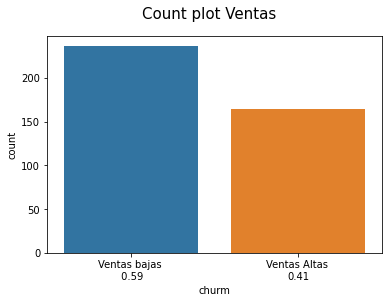

In [7]:
plot_bars(y, title = 'Ventas', c_churm='Ventas Altas', c_n_churm='Ventas bajas')

Hay un desbalance en el conjunto de datos del 59% registros son para ventas bajas y 41% son para ventas altas.



In [8]:
data.shape

(400, 11)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 1234, shuffle=True)

# **Transform data**
---

In [10]:
cat_cols = X_train.select_dtypes(include=['object']).columns.to_list()
numeric_cols = X_train.select_dtypes(include=['float64', 'int64']).columns.to_list()

In [11]:
cat_cols

['ShelveLoc', 'Urban', 'US']

In [12]:
#OnehotEncoding

preprocesor = ColumnTransformer(
    [('onehot', OneHotEncoder(handle_unknown='ignore'), cat_cols)],
    remainder = 'passthrough'
)

In [13]:
X_train_prep = preprocesor.fit_transform(X_train)
X_test_prep = preprocesor.transform(X_test)

In [14]:
encoded_cat = preprocesor.named_transformers_['onehot'].get_feature_names(cat_cols)
encoded_cat

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


array(['ShelveLoc_Bad', 'ShelveLoc_Good', 'ShelveLoc_Medium', 'Urban_No',
       'Urban_Yes', 'US_No', 'US_Yes'], dtype=object)

In [15]:
labels = np.concatenate([numeric_cols, encoded_cat])
labels

array(['CompPrice', 'Income', 'Advertising', 'Population', 'Price', 'Age',
       'Education', 'ShelveLoc_Bad', 'ShelveLoc_Good', 'ShelveLoc_Medium',
       'Urban_No', 'Urban_Yes', 'US_No', 'US_Yes'], dtype=object)

In [16]:
X_train = pd.DataFrame(X_train_prep, columns=labels)
X_test  = pd.DataFrame(X_test_prep, columns=labels)
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 280 entries, 0 to 279
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CompPrice         280 non-null    float64
 1   Income            280 non-null    float64
 2   Advertising       280 non-null    float64
 3   Population        280 non-null    float64
 4   Price             280 non-null    float64
 5   Age               280 non-null    float64
 6   Education         280 non-null    float64
 7   ShelveLoc_Bad     280 non-null    float64
 8   ShelveLoc_Good    280 non-null    float64
 9   ShelveLoc_Medium  280 non-null    float64
 10  Urban_No          280 non-null    float64
 11  Urban_Yes         280 non-null    float64
 12  US_No             280 non-null    float64
 13  US_Yes            280 non-null    float64
dtypes: float64(14)
memory usage: 30.8 KB


En la implementación de RandomForestClassifier, la métrica devuelta como oob_score es el accuracy, si se desea otra, se tiene que recurrir al método oob_decision_function_() para obtener las predicciones y con ellas calcular la métrica de interés.

# **Grid Search basado en out-of-bag score**
---


In [17]:
parama_grid = ParameterGrid(
    {
        'n_estimators': [50, 100, 150],
        'max_features': [5, 7, 9],
        'max_depth'   : [None, 3, 10, 20],
        'criterion'   : ['gini', 'entropy']
    }
)

response = {'params': [], 'oob_accuracy': []}

for params  in parama_grid:
  model = RandomForestClassifier(
      oob_score = True,
      n_jobs    = -1,
      random_state = 123,
      **params 

  )
  model.fit(X_train, y_train)
  response['params'].append(params)
  response['oob_accuracy'].append(model.oob_score_)
  print(f"Modelo: {params} \u2713")


Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 5, 'n_estimators': 50} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 5, 'n_estimators': 100} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 5, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 7, 'n_estimators': 50} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 7, 'n_estimators': 100} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 7, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 9, 'n_estimators': 50} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 9, 'n_estimators': 100} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 9, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': 3, 'max_features': 5, 'n_estimators': 50} ✓
Modelo: {'criterion': 'gini', 'max_depth': 3, 'max_features': 5, 'n_estimators': 100} ✓
Modelo: {

In [18]:
resutado = pd.DataFrame(response)
resutado = pd.concat([resutado, resutado['params'].apply(pd.Series)], axis = 1)
resutado = resutado.sort_values('oob_accuracy', ascending=False)
resutado = resutado.drop(columns = 'params')
resutado.head(4)

,oob_accuracy,criterion,max_depth,max_features,n_estimators
61,0.807143,entropy,10.0,9,100
58,0.803571,entropy,10.0,7,100
70,0.800000,entropy,20.0,9,100
67,0.800000,entropy,20.0,7,100


In [19]:
print(f'Los mejores hiperparametros (oob-accuracy) son {resutado.iloc[0, 0]}, {resutado.iloc[0,:]["oob_accuracy"]}, accuracy')

Los mejores hiperparametros (oob-accuracy) son 0.8071428571428572, 0.8071428571428572, accuracy


In [20]:
# VERSIÓN PARALELIZADA
param_grid = ParameterGrid(
                {'n_estimators': [150],
                 'max_features': [5, 7, 9],
                 'max_depth'   : [None, 3, 10, 20],
                 'criterion'   : ['gini', 'entropy']
                }
            )

def eval_oob_error(X, y, modelo, params, verbose=True):
    """
    Función para entrenar un modelo utilizando unos parámetros determinados
    y que devuelve el out-of-bag error
    """
    modelo.set_params(
        oob_score    = True,
        n_jobs       = -1,
        random_state = 123,
        ** params            
    )
    
    modelo.fit(X, y)
    
    if verbose:
        print(f"Modelo: {params} \u2713")
        
    return{'params': params, 'oob_accuracy': modelo.oob_score_}


n_jobs     = multiprocessing.cpu_count() -1
pool       = multiprocessing.Pool(processes=n_jobs)
resultados = pool.starmap(
                eval_oob_error,
                [(X_train_prep, y_train, RandomForestClassifier(), params) for params in param_grid]
             )

resultados = pd.DataFrame(resultados)
resultados = pd.concat([resultados, resultados['params'].apply(pd.Series)], axis=1)
resultados = resultados.drop(columns = 'params')
resultados = resultados.sort_values('oob_accuracy', ascending=False)
resultados.head(4)

Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 5, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 7, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 9, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': 3, 'max_features': 5, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': 3, 'max_features': 7, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': 3, 'max_features': 9, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': 10, 'max_features': 5, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': 10, 'max_features': 7, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': 10, 'max_features': 9, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': 20, 'max_features': 5, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': 20, 'max_features': 7, 'n_estimators': 150} ✓
Modelo: {'criterio

,oob_accuracy,criterion,max_depth,max_features,n_estimators
1,0.796429,gini,NaN,7,150
10,0.796429,gini,20.0,7,150
22,0.792857,entropy,20.0,7,150
13,0.792857,entropy,NaN,7,150


In [21]:
print(f'Los mejores hiperparametros (oob-accuracy) son {resultados.iloc[0, 0]}, {resultados.iloc[0,:]["oob_accuracy"]}, accuracy')

Los mejores hiperparametros (oob-accuracy) son 0.7964285714285714, 0.7964285714285714, accuracy


# **Grid Search basado en validación cruzada**
---

In [22]:
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_features': [5, 7, 9],
    'max_depth'   : [None, 3, 10, 20],
    'criterion'   : ['gini', 'entropy']
}

# Recall por que la data está desbalanceada
grid = GridSearchCV(
        estimator  = RandomForestClassifier(random_state = 123),
        param_grid = param_grid,
        scoring    = 'recall',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits=5, n_repeats=3, random_state=123), 
        refit      = True,
        verbose    = 0,
        return_train_score = True
       )
grid.fit(X_train,y_train)

GridSearchCV(cv=RepeatedKFold(n_repeats=3, n_splits=5, random_state=123),
             estimator=RandomForestClassifier(random_state=123), n_jobs=1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 3, 10, 20],
                         'max_features': [5, 7, 9],
                         'n_estimators': [50, 100, 150]},
             return_train_score=True, scoring='recall')

In [23]:
respuesta = pd.DataFrame(grid.cv_results_)
respuesta.filter(regex = '(param*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(4)

,param_criterion,param_max_depth,param_max_features,param_n_estimators,mean_test_score,std_test_score,mean_train_score,std_train_score
3,gini,None,7,50,0.718358,0.100649,1.0,0.0
30,gini,20,7,50,0.718358,0.100649,1.0,0.0
41,entropy,None,7,150,0.718159,0.100602,1.0,0.0
68,entropy,20,7,150,0.718159,0.100602,1.0,0.0


In [24]:
# Como se escogio la metrica del recall por el desbalance vario el resultado
print(f'Los mejores hiperparametros (cv) son {grid.best_params_}, {grid.best_score_}, {grid.scoring}')

Los mejores hiperparametros (cv) son {'criterion': 'gini', 'max_depth': None, 'max_features': 7, 'n_estimators': 50}, 0.7183575058468336, recall


# **Prediccion**
---

In [25]:
final_model = grid.best_estimator_

In [26]:
y_pred = final_model.predict(X_test)

In [27]:
def consufion_matrix(validation: np.ndarray, prediction:np.ndarray, churm:str='churm', no_churm:str='no_churm',  title: str= 'Matriz de confusion', x_size:int=6, y_size:int=5)->np.ndarray:
  matrix = metrics.confusion_matrix(validation, prediction)
  fig, ax = plt.subplots(nrows= 1, ncols=  1, figsize = (x_size,y_size))
  sns.heatmap(matrix, annot=True, ax = ax, cmap=plt.cm.Blues, fmt = 'g', annot_kws={'size': 13})
  ax.set_title(title, size = 13)
  ax.xaxis.set_ticklabels([no_churm, churm])
  ax.yaxis.set_ticklabels([no_churm, churm])
  ax.tick_params(labelsize = 13)
  fig.show()
  return matrix

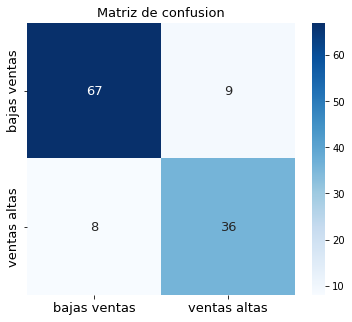

In [28]:
matrix = consufion_matrix(y_test, y_pred,'ventas altas', 'bajas ventas')

A partir de la matriz, el modelo parece tener un buen comportamiento en la predicción de las ubicaciones donde habra altas ventas de las sillas de bebe para coche.


In [29]:
def metricas(validation: np.ndarray, prediction:np.ndarray, matrix:np.ndarray, label:list=[1], label_title:str='Target')->None:
  print(f'Accuracy  :   {metrics.accuracy_score(validation, prediction)}')
  print(f'Kappa     :   {metrics.cohen_kappa_score(validation, prediction)}')
  print(f'predicción {label_title}')
  print(f'Precision:   {metrics.precision_score(validation, prediction, labels=label, average="macro")}')
  print(f'Recall    :   {metrics.recall_score(validation, prediction, labels=label, average="macro")}')

  VN = matrix[0,0]
  FP = matrix[0,1]
  specificity = VN/(VN+FP)

  print(f'Specificity:   {specificity}')
  print(f'F1-score   :   {metrics.f1_score(validation, prediction, labels=label, average="macro")}' )

In [30]:
metricas(y_test, y_pred, matrix, label_title='probabilidad de morir en 5 años')

Accuracy  :   0.8583333333333333
Kappa     :   0.6964285714285714
predicción probabilidad de morir en 5 años
Precision:   0.8
Recall    :   0.8181818181818182
Specificity:   0.881578947368421
F1-score   :   0.8089887640449439


El modelo tiene un buen rendimiento del 81% de la sensibilidad y el 88 en la media armonica entre la sensibilidad y le precición, tras optimizar los hiperparametros.

# **Prediccion Probabilidades**
---
Predecir la probabilidad para comprender la seguridad con la que el modelo realiza la asignación de categorias.

In [31]:
prediction_proba = final_model.predict_proba(X_test)
prediction_proba[:5, :]

array([[0.74, 0.26],
       [0.54, 0.46],
       [0.98, 0.02],
       [0.5 , 0.5 ],
       [0.38, 0.62]])

In [35]:
df_prediction = pd.DataFrame(prediction_proba, columns=['0', '1'])
df_prediction['Clasification'] = np.where(df_prediction['0']>df_prediction['1'], 0, 1)
df_prediction.head()

,0,1,Clasification
0,0.74,0.26,0
1,0.54,0.46,0
2,0.98,0.02,0
3,0.50,0.50,1
4,0.38,0.62,1


In [36]:
#Inversión en las tiendas con umbral superior al 80%
df_prediction['Clasification_0.8'] = np.where(df_prediction['1']>0.8, 1, 0)
df_prediction.head()

,0,1,Clasification,Clasification_0.8
0,0.74,0.26,0,0
1,0.54,0.46,0,0
2,0.98,0.02,0,0
3,0.50,0.50,1,0
4,0.38,0.62,1,0


# **Importancia predictores por pureza de nodos**
---

In [39]:
importance_predict = pd.DataFrame(
    {
        'Predictor'  : X_train.columns,
        'Importancia': final_model.feature_importances_
    }
)

print('Importancia de predictores')
importance_predict.sort_values('Importancia', ascending=False)

Importancia de predictores


,Predictor,Importancia
11,Urban_Yes,0.199305
9,ShelveLoc_Medium,0.131326
12,US_No,0.129969
7,ShelveLoc_Bad,0.107249
8,ShelveLoc_Good,0.103524
1,Income,0.088540
10,Urban_No,0.066462
0,CompPrice,0.058668
13,US_Yes,0.046215
2,Advertising,0.023669


# **Importancia predictores por importancia por permutación**
---

In [44]:
importancia = permutation_importance(
    estimator = final_model,
    X = X_train,
    y = y_train,
    n_repeats = 5,
    scoring   = 'neg_root_mean_squared_error',
    n_jobs       = multiprocessing.cpu_count() - 1,
    random_state = 123
)

In [45]:
importance_predict = pd.DataFrame(
    {k: importancia[k] for k in ['importances_mean', 'importances_std']}
)

In [46]:
importance_predict['feature'] = X_train.columns
importance_predict.sort_values('importances_mean', ascending=False)

,importances_mean,importances_std,feature
11,0.419185,0.026698,Urban_Yes
1,0.307733,0.031852,Income
9,0.297907,0.023180,ShelveLoc_Medium
7,0.257388,0.013423,ShelveLoc_Bad
12,0.255689,0.018363,US_No
0,0.229834,0.005791,CompPrice
8,0.201246,0.014635,ShelveLoc_Good
10,0.099115,0.013277,Urban_No
13,0.083364,0.013906,US_Yes
3,0.011952,0.023905,Population


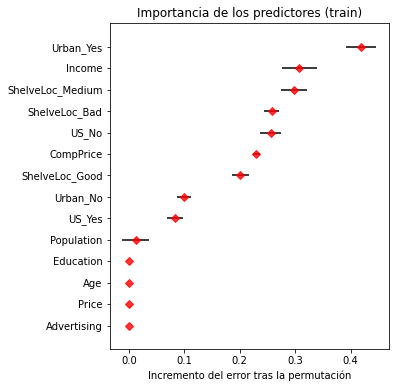

In [48]:
fig, ax = plt.subplots(figsize=(5, 6))
importance_predict = importance_predict.sort_values('importances_mean', ascending=True)
ax.barh(
    importance_predict['feature'],
    importance_predict['importances_mean'],
    xerr=importance_predict['importances_std'],
    align='center',
    alpha=0
)
ax.plot(
    importance_predict['importances_mean'],
    importance_predict['feature'],
    marker="D",
    linestyle="",
    alpha=0.8,
    color="r"
)
ax.set_title('Importancia de los predictores (train)')
ax.set_xlabel('Incremento del error tras la permutación');

In [ ]:
print('Los metodos de predictores por pureza de nodo y por permutación identifican las mejores predictores como Urban, Income y ShelveLoc')